#PySpark Installation

In [ ]:
!pip install pyspark py4j

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=c359187e797a3045b733c1b7833716a990c6a45054e4b29e2d4fdfcaf9850f18
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
!pip show pyspark

Name: pyspark
Version: 3.5.1
Summary: Apache Spark Python API
Home-page: https://github.com/apache/spark/tree/master/python
Author: Spark Developers
Author-email: dev@spark.apache.org
License: http://www.apache.org/licenses/LICENSE-2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: py4j
Required-by: 


In [ ]:
# General Imports
import pandas as pd
import numpy as np
import matplotlib
import math
import matplotlib.pyplot as plt
import itertools
from tabulate import tabulate
from sklearn.preprocessing import MinMaxScaler
from pyspark import SparkFiles
from pyspark.sql import Window
from pyspark import SparkContext, SparkConf
from pyspark.sql.types import StructType, StructField, DateType, StringType, DoubleType, IntegerType,FloatType
from pyspark.sql.functions import *
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import MinMaxScaler

In [ ]:
# Suppress Runtime Warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# start the spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("Stock Prediction").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)  # Property used to format output tables better

##Loading dataset

In [ ]:
url = 'https://cs6350bigdataproject.s3.us-east-2.amazonaws.com/sp500_stocks.csv'
spark.sparkContext.addFile(url)
table_schema = StructType([
    StructField("Date", DateType(), nullable=True),
    StructField("Symbol", StringType(), nullable=True),
    StructField("Adj Close", DoubleType(), nullable=True),
    StructField("Close", DoubleType(), nullable=True),
    StructField("High", DoubleType(), nullable=True),
    StructField("Low", DoubleType(), nullable=True),
    StructField("Open", DoubleType(), nullable=True),
    StructField("Volume", IntegerType(), nullable=True)
])

df = spark.read.csv("file://"+SparkFiles.get("sp500_stocks.csv"), header=True, schema= table_schema)

##Filtering data based on our required Range

In [ ]:
start_date = '2018-01-01'
end_date = '2023-12-31'
market_data = df.filter((df["Date"] >= start_date) & (df["Date"] <= end_date))
display(market_data)

Date,Symbol,Adj Close,Close,High,Low,Open,Volume
2018-01-02,MMM,147.14239501953125,197.02340698242188,198.2190704345703,194.65719604492188,197.14047241210938,3505476
2018-01-03,MMM,147.13613891601562,197.01504516601562,197.09866333007812,195.05853271484375,196.5468292236328,2623665
2018-01-04,MMM,149.0594482421875,199.59030151367188,200.20066833496094,197.71739196777344,198.16053771972656,2682748
2018-01-05,MMM,150.22096252441406,201.14549255371094,201.42140197753906,198.77926635742188,199.54013061523438,2195736
2018-01-08,MMM,149.73385620117188,200.49331665039062,201.45484924316406,199.9832763671875,200.15049743652344,2235324
2018-01-09,MMM,150.66424560546875,201.7391357421875,202.15719604492188,200.11705017089844,200.33444213867188,2027340
2018-01-10,MMM,150.5768280029297,201.6220703125,202.81771850585938,200.69398498535156,201.50502014160156,1962516
2018-01-11,MMM,151.30740356445312,202.60032653808594,202.6254119873047,200.45986938476562,201.28762817382812,1779289
2018-01-12,MMM,152.65621948242188,204.40635681152344,205.6856231689453,202.7592010498047,203.23577880859375,2361263
2018-01-16,MMM,152.8248291015625,204.63211059570312,206.68060302734375,203.87123107910156,205.10032653808594,2883676


In [ ]:
# drop unnecessary columns
columns_to_drop = ["Close", "Open", "High", "Low", "Symbol"]
market_data = market_data.drop(*columns_to_drop)

# drop missing values and duplicates
market_data = market_data.dropna()
market_data = market_data.dropDuplicates()

In [ ]:
display(market_data)

Date,Adj Close,Volume
2018-04-12,136.0949249267578,2742308
2018-09-14,132.85325622558594,2059034
2019-10-16,107.6068115234375,2314499
2020-09-22,112.53248596191406,2516145
2022-09-21,86.5150146484375,4468017
2019-06-18,41.271244049072266,2038800
2019-07-23,40.74224090576172,1966800
2020-01-23,43.0275993347168,2146600
2020-04-30,39.470027923583984,2208700
2020-05-14,37.51422882080078,1651400


In [ ]:
# function to divide the market capital by the appropriate divisor
def divide_index_sum(date,index_sum):
  divisors = {
            2018: {'Q1': 8518.41, 'Q2': 8474.31, 'Q3': 8434.96, 'Q4': 8387.79},
            2019: {'Q1': 8332.84, 'Q2': 8302.34, 'Q3': 8300.00, 'Q4': 8282.73},
            2020: {'Q1': 8289.27, 'Q2': 8269.11, 'Q3': 8286.67, 'Q4': 8428.67},
            2021: {'Q1': 8462.19, 'Q2': 8452.53, 'Q3': 8482.43, 'Q4': 8467.26},
            2022: {'Q1': 8451.33, 'Q2': 8427.99, 'Q3': 8399.95, 'Q4': 8369.04},
            2023: {'Q1': 8357.13, 'Q2': 8350.37, 'Q3': 8380.85, 'Q4': 8394.13}
            }
  if date.month in [1,2,3]:
    quarter = 'Q1'
  elif date.month in [4,5,6]:
    quarter = 'Q2'
  elif date in [7,8,9]:
    quarter = 'Q3'
  else:
    quarter = 'Q4'
  return index_sum / (divisors[date.year][quarter] * 1e4)



# calculates the S&P 500 Index
def calculate_Index(dataset):
  #Filtering the values between the below date ranges
  start_date = '2018-01-01'
  end_date = '2023-12-31'
  market_data = dataset.filter((df["Date"] >= start_date) & (df["Date"] <= end_date))

  #Calculating the total market capital of each company
  market_data = market_data.withColumn("Market_Capital", market_data["Adj Close"] * market_data["Volume"])
  columns_to_drop = ["Symbol","Adj Close","Close","High","Low","Open","Volume"]
  market_data = market_data.drop(*columns_to_drop)

  #Calculating the total market capitalization
  market_data = market_data.groupBy("Date").agg(sum("Market_Capital").alias("S&P500_Sum"))

  #Calculating the S&P index value using the divisors
  index_udf = udf(divide_index_sum, DoubleType())
  market_data = market_data.withColumn("S&P500_Index",index_udf(market_data["Date"],market_data["S&P500_Sum"])).drop("S&P500_Sum")
  market_data.show()
  return market_data


In [ ]:
# standardize the data using MinMaxScaler()
def scaling(train_unscaled,test_unscaled):
  scaler = MinMaxScaler(inputCol="features", outputCol="S&P500_Index")
  schema = ArrayType(DoubleType())

  train_unscaled_rdd = train_unscaled.rdd.map(lambda x: (Vectors.dense(x),)).toDF(["features"])
  test_unscaled_rdd = test_unscaled.rdd.map(lambda x: (Vectors.dense(x),)).toDF(["features"])

  scaler_model = scaler.fit(train_unscaled_rdd)
  train = scaler_model.transform(train_unscaled_rdd).select("S&P500_Index")
  test= scaler_model.transform(test_unscaled_rdd).select("S&P500_Index")
  return train,test

In [ ]:
# function to split the data into training and testing data with specified sequence token length
def TrainTestSplit(train,test,token_length):
  train = np.array(train.toPandas()["S&P500_Index"].tolist())
  test = np.array(test.toPandas()["S&P500_Index"].tolist())
  x_train_sequences, y_train_sequences, x_test_sequences, y_test_sequences = [], [], [], []

  for i in range(token_length, len(train) - 1):
    x_train_sequences.append(train[i-token_length : i,0])
    y_train_sequences.append(train[i : i+1,0])

  for i in range(token_length, len(test) - 1):
    x_test_sequences.append(test[i-token_length : i,0])
    y_test_sequences.append(test[i : i+1,0])


  x_train_seq = np.array(x_train_sequences)
  y_train_seq = np.array(y_train_sequences)
  x_test_seq = np.array(x_test_sequences)
  y_test_seq = np.array(y_test_sequences)

  return x_train_seq,y_train_seq,x_test_seq,y_test_seq

In [ ]:
# generate sequences of training and testing data
def Preprocess(token_length,market_data):
  SP_Index = calculate_Index(market_data)
  SP_Index = SP_Index.orderBy(col("date"))

  TotalCount = SP_Index.count()
  SplitCount = int(TotalCount * 0.8)

  train_unscaled = SP_Index.select("S&P500_Index").limit(SplitCount)
  test_unscaled = SP_Index.select("S&P500_Index").subtract(train_unscaled)

  train,test=scaling(train_unscaled,test_unscaled)
  x_train_seq,y_train_seq,x_test_seq,y_test_seq=TrainTestSplit(train,test,token_length)
  return x_train_seq,y_train_seq,x_test_seq,y_test_seq

In [ ]:
# Create a log file and try different parameters for the GRU model
def hyperparameter_tuning():
  with open("gru_logs.txt", 'w') as logfile:
    # Different values for our parameters
    sequence_lengths = [3,4,5]

    learning_rates = [0.001, 0.0001, 0.00001]
    epochs = [25, 50, 100]
    hidden_sizes = [5, 10, 20]

    values = []


    for sequence_length, learning_rate, num_epochs, hidden_size in itertools.product(sequence_lengths,
                                                                                    learning_rates,
                                                                                    epochs,
                                                                                    hidden_sizes):

      x_train_seq, y_train_seq, x_test_seq, y_test_seq = Preprocess(sequence_length,market_data)
      gru = GRU(x_train=x_train_seq,
            y_train=y_train_seq,
            learning_rate=learning_rate,
            num_epochs=num_epochs,
            input_size=1,
            hidden_size=hidden_size,
            output_size=1,
            sequence_length=sequence_length)
      # train the model
      gru.fit()

      # store the outputs
      train_err=gru.train_errs()
      test_output = gru.predict(x_test_seq)
      test_err = MSE(y_test_seq,test_output)

      # add to log file
      values.append({'sequence_length': sequence_length,
                      'learning_rate': learning_rate,
                      'num_epochs': num_epochs,
                      'hidden_size': hidden_size,
                      'train_err': train_err,
                      'test_err': test_err,
                      'x_train': x_train_seq,
                      'y_train': y_train_seq,
                      'x_test': x_test_seq,
                      'y_test': y_test_seq})

    tabulate_values = [list(d.values())[:6] for d in values]

    # Write the primary parameters and errors to the logfile
    logfile.write(tabulate(tabulate_values,
                  headers=['Sequence Length', 'Learning Rate', 'Number of Epochs',
                          'Hidden Size', 'Training Error', 'Testing Error'],
                  floatfmt=["", "", "", "", ".4f", ".4f"]))

  return values

In [ ]:
# function to compute squared difference for MSE
def squared_difference(pair):
    actual, predicted = pair
    return (predicted - actual) ** 2

# computes the MSE between two RDDs
def MSE(rdd1,rdd2):
  squared_diffs_rdd = rdd1.zip(rdd2).map(squared_difference)
  total_squared_diffs = squared_diffs_rdd.reduce(lambda x, y: x + y)

  mse = math.sqrt(total_squared_diffs / rdd2.count())

  return mse


In [ ]:
# Implementation of the GRU model
class GRU:

    # Randomly initialize weight and bias matrices with the given input and
    # hidden layer sizes
    def __init__(self, x_train, y_train, learning_rate, num_epochs, input_size, hidden_size, output_size, sequence_length):
      self.x_train = x_train
      self.y_train = y_train
      self.learning_rate = learning_rate
      self.num_epochs = num_epochs
      self.input_size = input_size
      self.hidden_size = hidden_size
      self.output_size = output_size
      self.num_sequences, self.sequence_length = self.x_train.shape[1], self.x_train.shape[2]
      self.weights = {}

      # Weights and bias for Update gate
      self.weights['W_xz'] = np.random.randn(self.hidden_size, self.input_size)
      self.weights['W_hz'] = np.random.randn(self.hidden_size, self.hidden_size)
      self.weights['b_z'] = np.zeros((self.hidden_size, 1))

      # Weights and bias for Reset gate
      self.weights['W_xr'] = np.random.randn(self.hidden_size, self.input_size)
      self.weights['W_hr'] = np.random.randn(self.hidden_size, self.hidden_size)
      self.weights['b_r'] = np.zeros((self.hidden_size, 1))

      # Weights and bias for Candidate hidden state
      self.weights['W_xh'] = np.random.randn(self.hidden_size, self.input_size)
      self.weights['W_hh'] = np.random.randn(self.hidden_size, self.hidden_size)
      self.weights['b_h'] = np.zeros((self.hidden_size, 1))

      # Weights and bias for output
      self.weights['W_o'] = np.random.randn(self.output_size, self.hidden_size)
      self.weights['b_o'] = np.zeros((self.output_size, 1))

      # Hidden state information
      self.ho = np.zeros((self.hidden_size, self.num_sequences))
      self.dh = np.zeros((self.hidden_size, self.num_sequences, self.sequence_length))


    # Sigmoid activation function
    def sigmoid(self, x):
      return (1 / (1 + np.exp(-x)))

    # Derivative of sigmoid activation function
    def d_sigmoid(self, x):
      return np.multiply(self.sigmoid(x), 1 - self.sigmoid(x))

    # Tanh activation function
    def tanh(self, x):
      return ((np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x)))

    # Derivative of Tanh activation function
    def d_tanh(self, x):
      return 1 - np.square(self.tanh(x))


    # Train the model for the given number of epochs
    def fit(self):
      self.train_errs = []
      for epoch in range(self.num_epochs):

        # Forward pass
        preds, h, layer_params = self.forward()

        # Compute Mean Sum of Squared Error
        train_err = np.sum(np.square((preds - self.y_train))) / (self.sequence_length * self.num_sequences)
        self.train_errs.append(train_err)

        # Backprogapation
        self.backpropagate(layer_params)

        # Update Weights, Biases, and State parameters
        for w in self.weights:
          if w not in ['W_o', 'b_o']:
            self.weights[w] -= np.multiply(self.learning_rate, self.gradients['d' + w])
        self.dh -= np.multiply(self.learning_rate, self.gradients['dh_previous'])

    # Forward propagation logic for the (entire) GRU model
    def forward(self):
      # Store the calculated paramaters for every layer to use during backpropagation
      layer_parameters = []

      # Initialize state information
      h = np.zeros((self.hidden_size, self.num_sequences, self.sequence_length))
      preds = np.zeros((self.output_size, self.num_sequences, self.sequence_length))
      h_out = self.ho

      # Go through every layer/cell in the GRU model
      for layer in range(self.sequence_length):
        layer_preds, h_out, layer_params = self.forward_(self.x_train[:,:,layer], h_out)
        h[:,:,layer] = h_out
        preds[:,:,layer] = layer_preds
        layer_parameters.append(layer_params)

      return preds, h, layer_parameters

    # Forward propagation logic for the GRU model (for each individual layer/cell)
    def forward_layer(self, x, h_previous):

      # Update gate computation with sigmoid activation function
      z = self.sigmoid(np.dot(self.weights['W_xz'], x) + np.dot(self.weights['W_hz'], h_previous) + self.weights['b_z'])

      # Reset gate computation with sigmoid activation function
      r = self.sigmoid(np.dot(self.weights['W_xr'], x) + np.dot(self.weights['W_hr'], h_previous) + self.weights['b_r'])

      # Candidate hidden state computation with tanh activation function
      h_hat = self.tanh(np.dot(self.weights['W_xh'], x) + np.dot(self.weights['W_hh'], r * h_previous) + self.weights['b_h'])

      # Update the hidden state
      h_out = np.multiply(z, h_previous) + np.multiply((1 - z), h_hat)

      # Predict the output for the given input
      preds = np.dot(self.weights['W_o'], h_out) + self.weights['b_o']

      # Store the computed parameters for backpropagation
      layer_params = [z, r, h_hat, h_out, h_previous, x]

      return preds, h_out, layer_params

    # Backpropagation logic for the (entire) GRU model
    def backpropagate(self, layer_params):
      self.gradients = {}

      # Weights and bias for Update gate
      self.gradients['dW_xz'] = np.random.randn(self.hidden_size, self.input_size)
      self.gradients['dW_hz'] = np.random.randn(self.hidden_size, self.hidden_size)
      self.gradients['db_z'] = np.zeros((self.hidden_size, 1))

      # Weights and bias for Reset gate
      self.gradients['dW_xr'] = np.random.randn(self.hidden_size, self.input_size)
      self.gradients['dW_hr'] = np.random.randn(self.hidden_size, self.hidden_size)
      self.gradients['db_r'] = np.zeros((self.hidden_size, 1))

      # Weights and bias for Candidate hidden state
      self.gradients['dW_xh'] = np.random.randn(self.hidden_size, self.input_size)
      self.gradients['dW_hh'] = np.random.randn(self.hidden_size, self.hidden_size)
      self.gradients['db_h'] = np.zeros((self.hidden_size, 1))

      # Weights and bias for output
      self.gradients['dx'] = np.zeros((self.input_size, self.num_sequences, self.sequence_length))
      self.gradients['dh_previous'] = np.zeros((self.hidden_size, self.num_sequences, self.sequence_length))

      # Go through every layer/cell in the GRU model
      for layer in range(self.sequence_length-1, -1, -1):
        self.backpropagate_layer(self.dh[:,:,layer], layer, layer_params[layer])

    def backpropagate_layer(self, dh, layer, layer_params):
      # Get the gradient of each computed parameter from layer parameters
      z, r, h_hat, h_out, h_previous, x = layer_params

      # Update gate gradient
      dz1 = np.multiply(dh, h_hat)
      dz2 = np.multiply(dh, h_previous)
      dz3 = dz1 + 1 - dz2
      dz4 = self.d_sigmoid(z)
      dz = np.multiply(dz3, dz4)

      # Candidate hidden state gradient
      dhhat1 = np.multiply(dh, z)
      dhhat2 = self.d_tanh(h_hat)
      dhhat = np.multiply(dhhat1, dhhat2)

      # Reset gate gradient
      dr1 = np.dot(np.transpose(self.weights["W_hh"]), dhhat)
      dr2 = np.multiply(dr1, r)
      dr3 = self.d_sigmoid(r)
      dr = np.multiply(dr2, dr3)

      # Hidden state gradient
      dh1 = np.dot(np.transpose(self.weights["W_hh"]), dhhat)
      dh2 = np.multiply(dh1, r)
      dh3 = np.multiply(1- z, dh)
      dh4 = np.dot(np.transpose(self.weights["W_hh"]), dr)
      dh5 = np.dot(np.transpose(self.weights["W_hh"]), dz)
      dh = dh2 + dh3 + dh4 + dh5

      # Output gradient
      dx1 = np.dot(np.transpose(self.weights["W_xh"]), dhhat)
      dx2 = np.dot(np.transpose(self.weights["W_xh"]), dz)
      dx3 = np.dot(np.transpose(self.weights["W_xh"]), dr)
      dx = dx1 + dx2 + dx3

      # Compute the final weight and bias gradients

      # Update gate weights and bias
      self.gradients['dW_xz'] += np.dot(dz, np.transpose(x))
      self.gradients['dW_hz'] += np.dot(dz, np.transpose(h_previous))
      self.gradients['db_z'] += np.sum(dz, axis=1, keepdims=True)

      # Reset gate weights and bias
      self.gradients['dW_xr'] += np.dot(dr, np.transpose(x))
      self.gradients['dW_hr'] += np.dot(dr, np.transpose(h_previous))
      self.gradients['db_r'] += np.sum(dr, axis=1, keepdims=True)

      # Weights and bias for Candidate hidden state
      self.gradients['dW_xh'] += np.dot(dh, np.transpose(x))
      self.gradients['dW_hh'] += np.dot(dh, np.transpose(np.multiply(h_previous, r)))
      self.gradients['db_h'] += np.sum(dh, axis=1, keepdims=True)

      # Output and hidden state gradients
      self.gradients['dx'][:,:,layer] = dx
      self.gradients['dh_previous'][:,:,layer] = dh

    # Prediction logic for the (entire) GRU model
    def predict(self, x_test):
      # Initialize state information
      h = np.zeros((self.hidden_size, x_test.shape[1], self.sequence_length))
      preds = np.zeros((self.output_size, x_test.shape[1], self.sequence_length))
      h_out = np.zeros((self.hidden_size, x_test.shape[1]))

      # Go through every layer/cell in the GRU model
      for layer in range(self.sequence_length):
        layer_preds, h_out = self.predict_layer(x_test[:,:,layer], h_out)
        h[:,:,layer] = h_out
        preds[:,:,layer] = layer_preds

      return preds

    # Prediction logic for the GRU model (for each individual layer/cell)
    def predict_layer(self, x, h_previous):

      # Update gate computation with sigmoid activation function
      z = self.sigmoid(np.dot(self.weights['W_xz'], x) + np.dot(self.weights['W_hz'], h_previous) + self.weights['b_z'])

      # Reset gate computation with sigmoid activation function
      r = self.sigmoid(np.dot(self.weights['W_xr'], x) + np.dot(self.weights['W_hr'], h_previous) + self.weights['b_r'])

      # Candidate hidden state computation with tanh activation function
      h_hat = self.tanh(np.dot(self.weights['W_xh'], x) + np.dot(self.weights['W_hh'], r * h_previous) + self.weights['b_h'])

      # Update the hidden state
      h_out = np.multiply(z, h_previous) + np.multiply((1 - z), h_hat)

      # Predict the output for the given input
      preds = np.dot(self.weights['W_o'], h_out) + self.weights['b_o']

      return preds, h_out

In [ ]:
def find_best_parameters(values):
  best_params = {}
  best_avg_err = 1e9

  for val_dict in values:
    avg_err = (val_dict['train_err'] + val_dict['test_err']) / 2
    if avg_err < best_avg_err:
      best_avg_err = avg_err
      best_params = val_dict

  print("Sequence Length: {}\nLearning Rate: {}\nNumber of Epochs: {}\nHidden Size: {}\nTraining Error: {:.4f}\nTesting Error: {:.4f}".format(
      best_params['sequence_length'],
      best_params['learning_rate'],
      best_params['num_epochs'],
      best_params['hidden_size'],
      best_params['train_err'],
      best_params['test_err']))

  return best_params

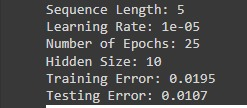

In [ ]:
def plot_original(best_params):
  fig = plt.subplots(figsize=(16, 5))

  plt.plot(best_params['train_dates'], best_params['train_indices'], color='r')


  plt.plot(best_params['test_dates'], best_params['test_indices'], color='b')

  plt.title("Daily S&P 500 Index (Unsequenced)")
  plt.legend(['Train', 'Test'])
  plt.xlabel('Date')
  plt.ylabel('Index Price (USD)')
  plt.show()

In [ ]:
def plot_sequenced(best_params):
  fig2 = plt.subplots(figsize=(16, 5))

  x_train = best_params['scaler'].inverse_transform(best_params['x_train'][0])
  x_train = [np.mean(arr) for arr in x_train]
  plt.plot(best_params['train_dates'], x_train, color='r')

  x_test = best_params['scaler'].inverse_transform(best_params['x_test'][0])
  x_test = [np.mean(arr) for arr in x_test]
  plt.plot(best_params['test_dates'], x_test, color='b')

  predicted_data = best_params['scaler'].inverse_transform(best_params['test_output'][0])
  predicted_data = [np.max(arr) for arr in predicted_data]
  plt.plot(best_params['test_dates'], predicted_data, color='g')

  plt.title("Daily S&P 500 Index (sequenced)")
  plt.legend(['Train', 'Test', 'Predicted'])
  plt.xlabel('Date')
  plt.ylabel('Index Price (USD)')
  plt.show()

In [ ]:
# Plot the training errors
def plot_errors(best_params):
  fig3 = plt.subplots(figsize=(5, 5))
  x = np.arange(0, best_params['num_epochs'])
  plt.plot(x, best_params['train_errs'], "r")

  plt.title("Training Errors Across {} Epochs".format(best_params['num_epochs']))
  plt.xlabel("Epochs")
  plt.ylabel("Error")
  plt.show()

In [ ]:
if __name__ == '__main__':

  # Try out different configurations of parameters via hyperparameter tuning
  parameter_values = hyperparameter_tuning()

  # Extract the best parameters based on the lowest average Training and Testing Errors
  best_params = find_best_parameters(parameter_values)

  # Plot the original S&P 500 training and testing data without sequencing
  plot_original(best_params)

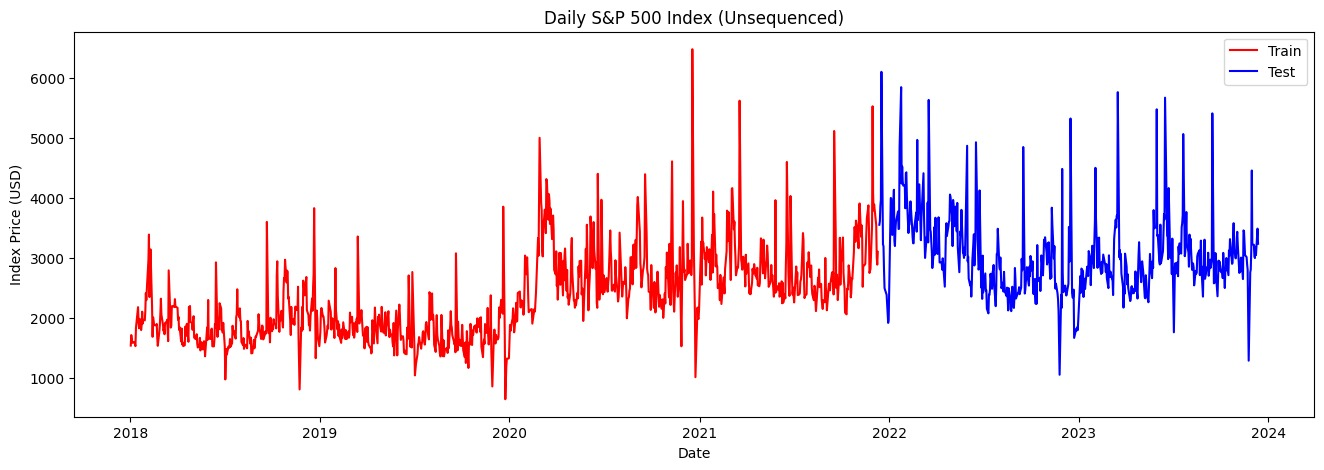